In [1]:
import pandas as pd
import numpy as np
import re, string
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, WordNetLemmatizer
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.backend import clear_session
from gensim import models

 
from numpy import zeros, asarray, array
from keras import layers
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, Input, Conv1D, concatenate
from keras.layers import GlobalMaxPooling1D, MaxPooling1D 
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
#loading plots to used later in graphing the model performance
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()


In [3]:
train_data, test_data = pd.read_csv('data/train.csv', header = None, delimiter=','), pd.read_csv('data/test.csv', header = None, delimiter=',')
train_data.columns, test_data.columns = ['text','label'], ['text','label']

#train, test = train.replace({'lable': {1: 'True', 0: 'False'}}), test.replace({'lable': {1: 'True', 0: 'False'}})
train_data.head(5)

,text,label
0,note : some may consider portions of the follo...,1
1,note : some may consider portions of the follo...,1
2,every once in a while you see a film that is s...,1
3,"when i was growing up in 1970s , boys in my sc...",1
4,"the muppet movie is the first , and the best m...",1


In [4]:
train_data["text"][1]

'note : some may consider portions of the following text to be spoilers .  be forewarned .  among my fanatical ticker tape-worshipping friends , there\'s one who happens to share the same philosophy espoused by the central character in darren aronofsky\'s darkly original pi : the entire stock market can be reduced to nothing but a series of patterns which , through analysis , will produce information to accurately forecast future behaviour .   ( an example of the mentality involved : if the stock price goes up like this , and then down like that , and then sharply up this way , it then will go * this * way . )  while i freely admit that i know less than nothing about the market ( knowledge check : prices up -- good ; prices down -- bad ; most of the time , at least ) and hence really couldn\'t comment with any authority , it\'s always nonetheless struck me as an incredibly naive oversimplification of an astonishingly complex system ( and besides , if it were that simple , no doubt some

In [5]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sen = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sen = re.sub(r"\s+[a-zA-Z]\s+", ' ', sen)

    # Removing multiple spaces
    sen = re.sub(r'\s+', ' ', sen)

    return sen

In [6]:
sentences_train = []
sentences_test = []

train_sentences = list(train_data['text'])
test_sentences = list(test_data['text'])

for sen in train_sentences:
    sentences_train.append(preprocess_text(sen))
    
for sen in test_sentences:
    sentences_test.append(preprocess_text(sen))

In [7]:
sentences_train[1]

'note some may consider portions of the following text to be spoilers be forewarned among my fanatical ticker tape worshipping friends there one who happens to share the same philosophy espoused by the central character in darren aronofsky darkly original pi the entire stock market can be reduced to nothing but series of patterns which through analysis will produce information to accurately forecast future behaviour an example of the mentality involved if the stock price goes up like this and then down like that and then sharply up this way it then will go this way while freely admit that know less than nothing about the market knowledge check prices up good prices down bad most of the time at least and hence really couldn comment with any authority it always nonetheless struck me as an incredibly naive oversimplification of an astonishingly complex system and besides if it were that simple no doubt somebody would ve already figured it all out the difference in this case is that while 

In [8]:
y_train = train_data['label'].values
y_test = test_data['label'].values

In [9]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences_train)

word_index = tokenizer.word_index

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [10]:
maxlen = 400

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [11]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath,'r', errors = 'ignore', encoding='utf8') as f:
        for line in f:
            try:
                word, *vector = line.split()
                if word in word_index:
                    idx = word_index[word] 
                    embedding_matrix[idx] = np.array(
                        vector, dtype=np.float32)[:embedding_dim]
            except:
                print(word)
                pass

    return embedding_matrix

In [12]:
                                 #embedding link: http://nlp.stanford.edu/data/glove.840B.300d.zip
    
file_path='C:/Users/cdwor/Desktop/glove.840B.300d.txt'
#file_path='C:/Users/cdwor/OneDrive/Education/University/Year 5/Data Wrangling/Coursework 2/data/glove.6B.100d.txt'
embedding_dim = 300
embedding_matrix = create_embedding_matrix(
    file_path,
    tokenizer.word_index, embedding_dim)

at
to
email
or
contact
on
by
in
at
at
is


In [13]:
print(embedding_matrix.shape)

(33828, 300)


In [14]:
print(embedding_matrix)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.27204001 -0.06203    -0.1884     ...  0.13015001 -0.18317001
   0.1323    ]
 [-0.18567     0.066008   -0.25209001 ... -0.023452    0.12302
   0.3312    ]
 ...
 [ 0.71087998  0.31716001  0.14848    ... -0.0027204   0.32440999
  -0.31963   ]
 [-0.1211      0.29692999  0.40535    ...  0.18128    -0.2053
  -0.60477   ]
 [-0.29899999  0.29299     0.45682001 ... -0.25531     0.55012
  -0.0039112 ]]


In [15]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.9369752867447085

In [84]:
def create_model(num_filters, kernel_size, vocab_size, embedding_dim, maxlen):
    model = Sequential()
    model.add(layers.Embedding(len(train_word_index)+1, EMBEDDING_DIM, weights=[train_embedding_weights], input_length=MAX_SEQUENCE_LENGTH, trainable=True))
    model.add(layers.Conv1D(200, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

# Main settings
embedding_dim = 100
maxlen = 400
output_file = 'data/output.txt'

val_data = pd.read_csv('data/val.csv', header = None, delimiter=',')
val_data.columns = ['text','label']

X = []
sentences = list(val_data['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

y = val_data['label'].values

# Train-test split
val_sentences_train, val_sentences_test, val_y_train, val_y_test = train_test_split(
    X, y, test_size=0.25, random_state=1000)

# Tokenize words
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(sentences_train)
X_train_val = tokenizer.texts_to_sequences(val_sentences_train)
X_test_val = tokenizer.texts_to_sequences(val_sentences_test)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

# Pad sequences with zeros
X_train_val = pad_sequences(X_train_val, padding='post', maxlen=maxlen)
X_test_val = pad_sequences(X_test_val, padding='post', maxlen=maxlen)


# Parameter grid for grid search
param_grid = dict(num_filters=[32, 64, 128],
                  kernel_size=[3, 5, 7],
                  vocab_size=[vocab_size],
                  embedding_dim=[embedding_dim],
                  maxlen=[maxlen],
                )

model = KerasClassifier(build_fn=create_model,
                        epochs=20, batch_size=16,
                        verbose=False)

grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid,
                          cv=4, verbose=1, n_iter=5)

grid_result = grid.fit(X_train_val, val_y_train)

# Evaluate testing set
test_accuracy = grid.score(X_test_val, val_y_test)

with open(output_file, 'a') as f:
    s = ('Running {} data set\nBest Accuracy : '
         '{:.4f}\n{}\nTest Accuracy : {:.4f}\n\n')
    output_string = s.format(
        "source",
        grid_result.best_score_,
        grid_result.best_params_,
        test_accuracy)
    print(output_string)
    f.write(output_string)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  3.7min finished


Running source data set
Best Accuracy : 0.5466
{'vocab_size': 33828, 'num_filters': 32, 'maxlen': 400, 'kernel_size': 7, 'embedding_dim': 100}
Test Accuracy : 0.6000




In [16]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
embedding_dim = 300

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=True))
model.add(layers.Conv1D(200, 6, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_m, precision_m, recall_m])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 300)          10148400  
_________________________________________________________________
conv1d (Conv1D)              (None, 395, 200)          360200    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                2010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 10,510,621
Trainable params: 10,510,621
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
88/88 [==============================] - 19s 204ms/step - loss: 0.6957 - accuracy: 0.5157 - f1_m: 0.5523 - precision_m: 0.4268 - recall_m: 0.8246 - val_loss: 0.6860 - val_accuracy: 0.5000 - val_f1_m: 0.5067 - val_precision_m: 0.5000 - val_recall_m: 0.5200
Epoch 2/50
88/88 [==============================] - 17s 199ms/step - loss: 0.6607 - accuracy: 0.5291 - f1_m: 0.6675 - precision_m: 0.5172 - recall_m: 0.9941 - val_loss: 0.6151 - val_accuracy: 0.5625 - val_f1_m: 0.5091 - val_precision_m: 0.5029 - val_recall_m: 0.5200
Epoch 3/50
88/88 [==============================] - 17s 193ms/step - loss: 0.4311 - accuracy: 0.8564 - f1_m: 0.8632 - precision_m: 0.8187 - recall_m: 0.9600 - val_loss: 0.3606 - val_accuracy: 0.8350 - val_f1_m: 0.4451 - val_precision_m: 0.5200 - val_recall_m: 0.3950
Epoch 4/50
88/88 [==============================] - 17s 193ms/step - loss: 0.0922 - accuracy: 0.9790 - f1_m: 0.9756 - precision_m: 0.9784 - recall_m: 0.9782 - val_loss: 0.4628 - val_accuracy: 0.8050 

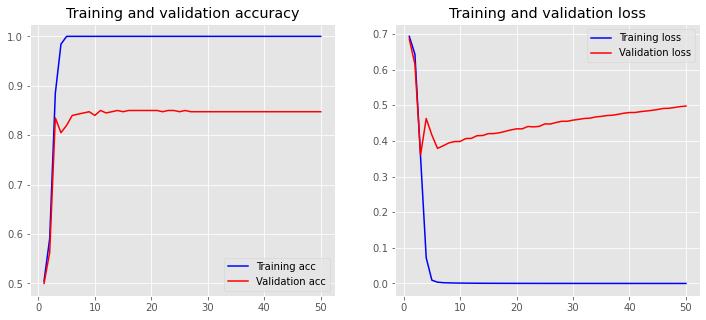

In [24]:
clear_session()
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=16)
plot_history(history)

In [20]:
loss, accuracy, f1_score, precision, recall = model.evaluate(X_test, y_test, verbose=0)

In [21]:
print(loss*100, accuracy*100, f1_score*100, precision*100, recall*100)

41.43114984035492 84.50000286102295 47.466060519218445 53.84615659713745 43.02884638309479


In [22]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

7/7 [==============================] - 1s 73ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.67       200
           1       0.00      0.00      0.00       200

    accuracy                           0.50       400
   macro avg       0.25      0.50      0.33       400
weighted avg       0.25      0.50      0.33       400



C:\Users\cdwor\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
